<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_gpr_laplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numpyro Jax PlayGround

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [1]:
#@title Install Packages
%%capture
!pip install jax jaxlib flax chex optax objax
!pip install "git+https://github.com/deepmind/dm-haiku"
!pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as np
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

In [3]:
#@title Data
def get_data(
    n_train: int = 30,
    input_noise: float = 0.15,
    output_noise: float = 0.15,
    n_test: int = 400,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, None]:
    onp.random.seed(0)
    X = np.linspace(-1, 1, n_train)
    Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y += output_noise * onp.random.randn(n_train)
    Y -= np.mean(Y)
    Y /= np.std(Y)

    X += input_noise * onp.random.randn(n_train)

    assert X.shape == (n_train,)
    assert Y.shape == (n_train,)

    X_test = np.linspace(-1.2, 1.2, n_test)

    return X[:, None], Y[:, None], X_test[:, None]


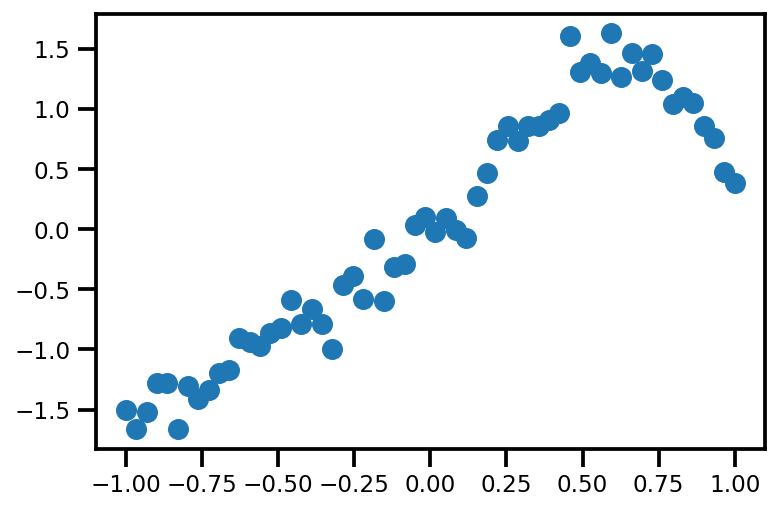

In [4]:
n_train = 60
input_noise = 0.0
output_noise = 0.1
n_test = 100

X, Y, Xtest = get_data(
    n_train=n_train, 
    input_noise=0.0, output_noise=output_noise, 
    n_test=n_test
)

fig, ax = plt.subplots()
ax.scatter(X, Y)

plt.show()

## Gaussian Process Model

In [36]:
import objax



# squared euclidean distance
def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return np.sum((x - y) ** 2)

# distance matrix
def distmat(func: Callable, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

# 1D covariance matrix
def rbf_kernel(X, Y, variance, length_scale):
    # distance formula
    deltaXsq = distmat(sqeuclidean_distance, X / length_scale, Y / length_scale)

    # rbf function
    K = variance * np.exp(-0.5 * deltaXsq)
    return K

class ExactGP(objax.Module):
    def __init__(self):
        self.var = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
        self.scale = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
        self.sigma = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)
        

    def model2(self, X, y=None):
        # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
        # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
        # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

        # Compute kernel
        K = rbf_kernel(X, X, self.var, self.scale)
        K += np.eye(X.shape[0]) * np.power(self.sigma, 2)

        # Sample y according to the standard gaussian process formula
        return numpyro.sample("y", dist.MultivariateNormal(
            loc=np.zeros(X.shape[0]),
            covariance_matrix=K), obs=y
        )

    def guide(self, X, y):
        pass


    def model(self, X, y=None):
        # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
        # ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
        # σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

        η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
        ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
        σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

        # Compute kernel
        K = rbf_kernel(X, X, η, ℓ)
        K += np.eye(X.shape[0]) * np.power(σ, 2)

        # Sample y according to the standard gaussian process formula
        return numpyro.sample("y", dist.MultivariateNormal(
            loc=np.zeros(X.shape[0]),
            covariance_matrix=K), obs=y
        )

    def guide(self, X, y):
        pass

    # Predictive Mean and Variance
    def predict(X, Y, X_test, variance, length_scale, noise):

        K = rbf_kernel(X, X, variance, length_scale)
        L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

        # Calculate the Mean
        K_x = rbf_kernel(X_test, X, variance, length_scale)
        mu_y = np.dot(K_x, alpha)

        # Calculate the variance
        v = jax.scipy.linalg.cho_solve(L, K_x.T)

        # Calculate kernel matrix for inputs
        K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

        cov_y = K_xx - np.dot(K_x, v)
        return mu_y, cov_y




In [40]:



# GP model.
def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
    ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
    σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

    # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    # ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    # σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

    # Compute kernel
    K = rbf_kernel(X, X, η, ℓ)
    K += np.eye(X.shape[0]) * np.power(σ, 2)

    # Sample y according to the standard gaussian process formula
    numpyro.sample("y", dist.MultivariateNormal(
        loc=np.zeros(X.shape[0]),
        covariance_matrix=K), obs=y
    )

def empty_guide(X, y):
    pass


def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, bool]:
    """Cholesky Factorization"""
    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

# Predictive Mean and Variance
def predict(X, Y, X_test, variance, length_scale, noise):

    K = rbf_kernel(X, X, variance, length_scale)
    L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

    # Calculate the Mean
    K_x = rbf_kernel(X_test, X, variance, length_scale)
    mu_y = np.dot(K_x, alpha)

    # Calculate the variance
    v = jax.scipy.linalg.cho_solve(L, K_x.T)

    # Calculate kernel matrix for inputs
    K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

    cov_y = K_xx - np.dot(K_x, v)
    return mu_y, cov_y


# Summarize function posterior.
def posterior(rng_key, X, Y, X_test, variance, length_scale, noise):
    m, cov = predict(X, Y, X_test, variance, length_scale, noise)

    return random.multivariate_normal(rng_key, mean=m, cov=cov)

def summarize_posterior(preds, ci=96):
    ci_lower = (100 - ci) / 2
    ci_upper = (100 + ci) / 2
    preds_mean = preds.mean(0)
    preds_lower = np.percentile(preds, ci_lower, axis=0)
    preds_upper = np.percentile(preds, ci_upper, axis=0)
    return preds_mean, preds_lower, preds_upper

In [41]:
K = rbf_kernel(X, X, 1.0, 1.0)

# check shape
chex.assert_shape(K, (n_train, n_train))

## Laplace Approximation

In [42]:
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import TraceMeanField_ELBO

In [72]:
# reproducibility
rng_key = random.PRNGKey(0)

# Setup
guide = numpyro.infer.autoguide.AutoLaplaceApproximation(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(GP, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(random.PRNGKey(1), 1_000, X, Y.squeeze())

100%|██████████| 1000/1000 [00:01<00:00, 509.75it/s, init loss: 12.4653, avg. loss [951-1000]: -3.8011]


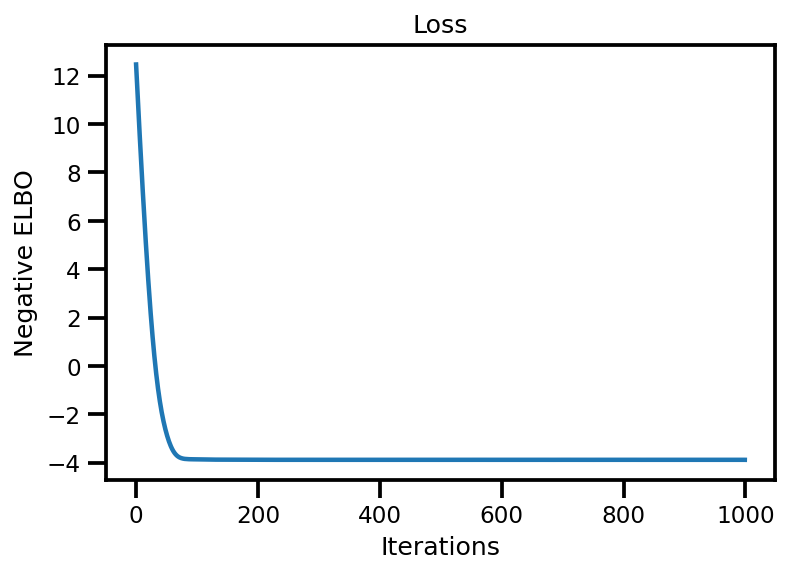

In [73]:
fig, ax = plt.subplots()

ax.plot(svi_result.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [79]:
params = svi_result.params
print(params)

quantiles = guide.median(params) 
print(quantiles)

{'auto_loc': DeviceArray([-0.537, -1.856,  0.959], dtype=float32)}
{'length_scale': DeviceArray(0.585, dtype=float32), 'noise': DeviceArray(0.156, dtype=float32), 'variance': DeviceArray(2.61, dtype=float32)}


In [80]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=quantiles['variance'], 
    length_scale=quantiles['length_scale'], 
    noise=quantiles['noise']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

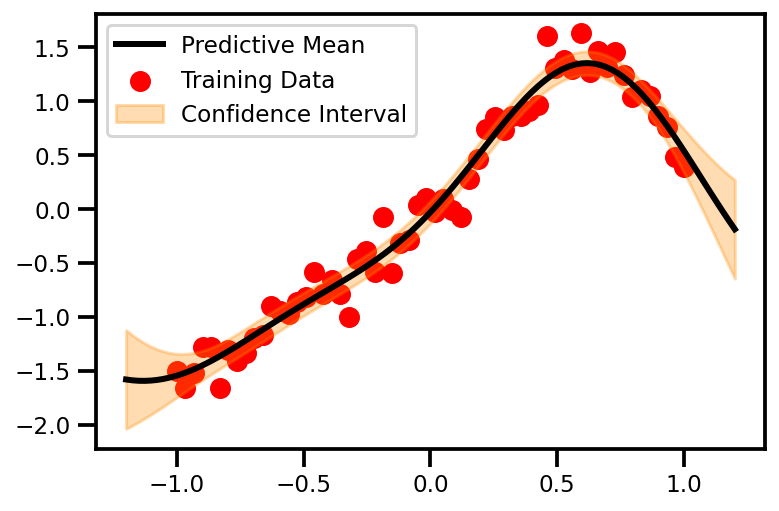

In [81]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

In [75]:
seed = 123
n_samples = 1_000

advi_samples = guide.sample_posterior(random.PRNGKey(seed), params, (n_samples,))

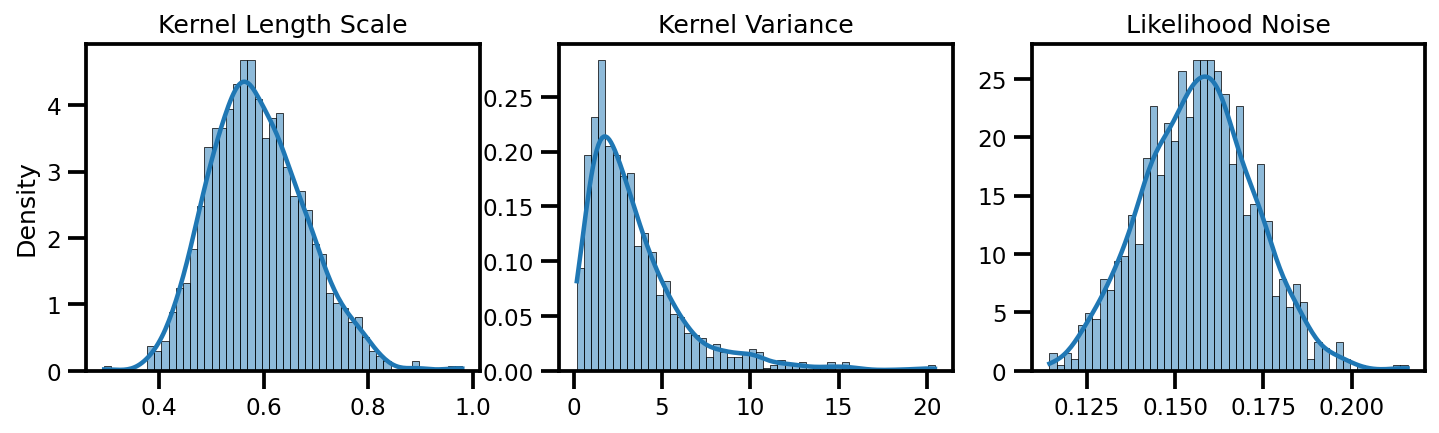

In [76]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=advi_samples['length_scale'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[1], x=advi_samples['variance'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[2], x=advi_samples['noise'], kde=True, bins=50, stat='density')

ax[0].set(title='Kernel Length Scale')
ax[1].set(title='Kernel Variance', ylabel="")
ax[2].set(title='Likelihood Noise', ylabel="")

plt.show()

#### Predictions

In [77]:
predictions, _ = jax.vmap(predict, in_axes=(None, None, None, 0, 0, 0), out_axes=(0, 0))(
    X, Y.squeeze(), Xtest,
    advi_samples['variance'],
    advi_samples['length_scale'],
    advi_samples['noise']
    )

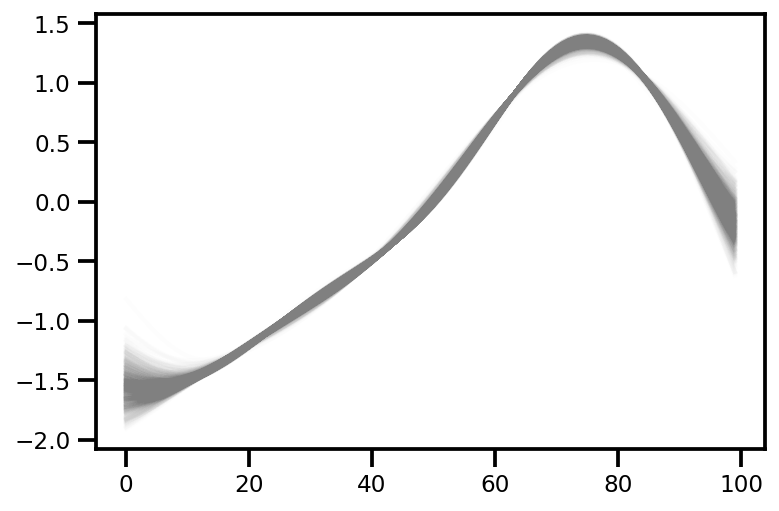

In [78]:
plt.plot(predictions.T, color='gray', alpha=0.01);

In [70]:
y_pred, y_lb, y_ub = summarize_posterior(predictions)

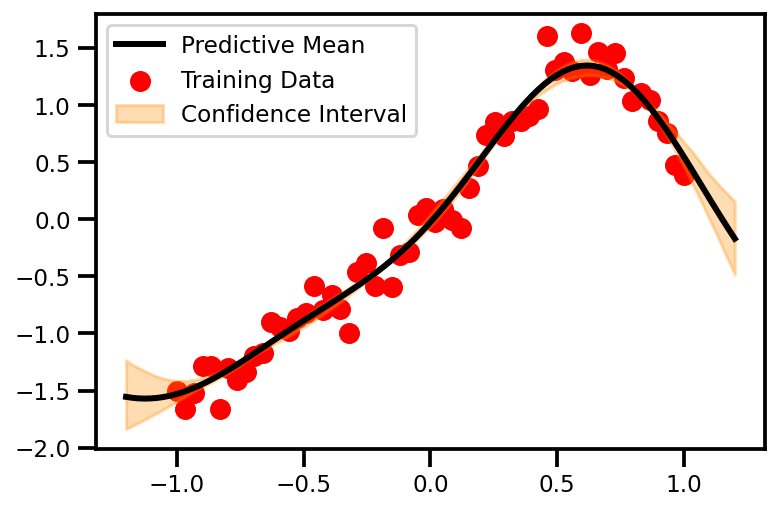

In [71]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(), 
    y_lb, 
    y_ub,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()
plt.show()